In [100]:
%load_ext tensorboard

import tensorflow as tf
import keras
from keras import layers
import yaml, datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [101]:
batch_size = 8
img_height = 256
img_width = 256

with open('config.yml', 'r') as file:
    paths = yaml.safe_load(file)

data_dir = paths['paths']['categories_path']

In [102]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

Found 5678 files belonging to 7 classes.
Using 4543 files for training.
Found 5678 files belonging to 7 classes.
Using 1135 files for validation.


2024-01-04 04:01:07.176176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4543]
	 [[{{node Placeholder/_0}}]]
2024-01-04 04:01:07.178083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4543]
	 [[{{node Placeholder/_0}}]]


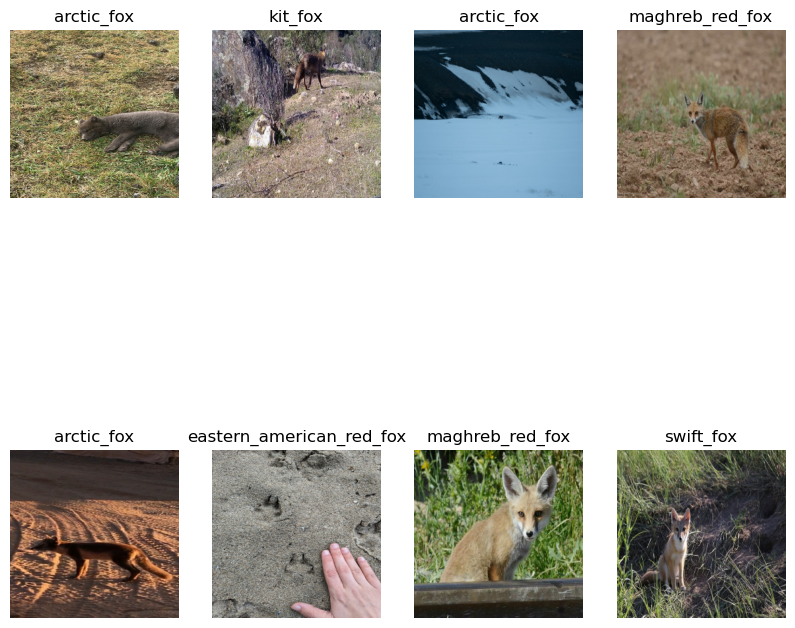

In [103]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [108]:
data_augmentation = keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
]
)

input = keras.Input(shape=(256, 256, 3))
x = data_augmentation(input)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu')(x)
x = layers.Flatten()(x)
output = layers.Dense(7, activation='softmax')(x)
model = keras.Model(inputs=input, outputs=output)

model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_12 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_79 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_80 (Conv2D)          (None, 125, 125, 32)      4640      
                                                          

In [109]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(train_ds, 
                    epochs=30, 
                    validation_data=val_ds, 
                    callbacks=[tensorboard_callback])

Epoch 1/30


133/568 [======>.......................] - ETA: 11s - loss: 1.8220 - accuracy: 0.2378

2024-01-04 04:12:23.748221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 21s 33ms/step - loss: 1.7613 - accuracy: 0.2699 - val_loss: 1.6609 - val_accuracy: 0.3003
Epoch 2/30
134/568 [======>.......................] - ETA: 11s - loss: 1.6956 - accuracy: 0.3424

2024-01-04 04:12:42.272191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 19s 33ms/step - loss: 1.6870 - accuracy: 0.3330 - val_loss: 1.6312 - val_accuracy: 0.3525
Epoch 3/30
133/568 [======>.......................] - ETA: 14s - loss: 1.6308 - accuracy: 0.3731

2024-01-04 04:13:02.139536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 22s 39ms/step - loss: 1.6432 - accuracy: 0.3608 - val_loss: 1.7494 - val_accuracy: 0.3446
Epoch 4/30
130/568 [=====>........................] - ETA: 15s - loss: 1.5853 - accuracy: 0.3798

2024-01-04 04:13:24.561050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 22s 38ms/step - loss: 1.6058 - accuracy: 0.3656 - val_loss: 1.5541 - val_accuracy: 0.3786
Epoch 5/30
133/568 [======>.......................] - ETA: 12s - loss: 1.5544 - accuracy: 0.4004

2024-01-04 04:13:45.743575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 19s 33ms/step - loss: 1.5859 - accuracy: 0.3916 - val_loss: 1.6717 - val_accuracy: 0.3342
Epoch 6/30
135/568 [======>.......................] - ETA: 12s - loss: 1.5297 - accuracy: 0.4120

2024-01-04 04:14:04.331002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 18s 32ms/step - loss: 1.5568 - accuracy: 0.3947 - val_loss: 1.6328 - val_accuracy: 0.3264
Epoch 7/30
133/568 [======>.......................] - ETA: 13s - loss: 1.5037 - accuracy: 0.4041

2024-01-04 04:14:22.883052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 21s 36ms/step - loss: 1.5414 - accuracy: 0.4022 - val_loss: 1.5092 - val_accuracy: 0.4204
Epoch 8/30
135/568 [======>.......................] - ETA: 12s - loss: 1.4867 - accuracy: 0.4389

2024-01-04 04:15:03.817247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 19s 33ms/step - loss: 1.5270 - accuracy: 0.4101 - val_loss: 1.5774 - val_accuracy: 0.3916
Epoch 9/30
135/568 [======>.......................] - ETA: 13s - loss: 1.4940 - accuracy: 0.4306

2024-01-04 04:15:24.488033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 19s 34ms/step - loss: 1.5294 - accuracy: 0.4085 - val_loss: 1.5817 - val_accuracy: 0.3603
Epoch 10/30
135/568 [======>.......................] - ETA: 12s - loss: 1.4706 - accuracy: 0.4250

2024-01-04 04:15:43.480563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 19s 34ms/step - loss: 1.4984 - accuracy: 0.4198 - val_loss: 1.6195 - val_accuracy: 0.3864
Epoch 11/30
135/568 [======>.......................] - ETA: 12s - loss: 1.4637 - accuracy: 0.4315

2024-01-04 04:16:03.047985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 20s 35ms/step - loss: 1.4938 - accuracy: 0.4239 - val_loss: 1.5964 - val_accuracy: 0.3864
Epoch 12/30
133/568 [======>.......................] - ETA: 13s - loss: 1.4612 - accuracy: 0.4248

2024-01-04 04:16:22.988551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 20s 36ms/step - loss: 1.4953 - accuracy: 0.4286 - val_loss: 1.4931 - val_accuracy: 0.3969
Epoch 13/30
132/568 [=====>........................] - ETA: 13s - loss: 1.4831 - accuracy: 0.4186

2024-01-04 04:16:43.509322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 21s 36ms/step - loss: 1.5037 - accuracy: 0.4206 - val_loss: 1.7165 - val_accuracy: 0.3995
Epoch 14/30
133/568 [======>.......................] - ETA: 13s - loss: 1.4745 - accuracy: 0.4258

2024-01-04 04:17:04.072204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 21s 36ms/step - loss: 1.4839 - accuracy: 0.4286 - val_loss: 1.5553 - val_accuracy: 0.4099
Epoch 15/30
134/568 [======>.......................] - ETA: 13s - loss: 1.4904 - accuracy: 0.4422

2024-01-04 04:17:24.761162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 21s 36ms/step - loss: 1.4793 - accuracy: 0.4378 - val_loss: 1.6549 - val_accuracy: 0.4021
Epoch 16/30
131/568 [=====>........................] - ETA: 13s - loss: 1.4647 - accuracy: 0.4485

2024-01-04 04:17:45.308893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 21s 37ms/step - loss: 1.4746 - accuracy: 0.4361 - val_loss: 1.5355 - val_accuracy: 0.3969
Epoch 17/30
134/568 [======>.......................] - ETA: 13s - loss: 1.4189 - accuracy: 0.4394

2024-01-04 04:18:06.420309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 21s 37ms/step - loss: 1.4791 - accuracy: 0.4367 - val_loss: 1.5481 - val_accuracy: 0.4726
Epoch 18/30
133/568 [======>.......................] - ETA: 14s - loss: 1.4782 - accuracy: 0.4464

2024-01-04 04:18:27.919504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 21s 37ms/step - loss: 1.4804 - accuracy: 0.4367 - val_loss: 1.6528 - val_accuracy: 0.4099
Epoch 19/30
133/568 [======>.......................] - ETA: 14s - loss: 1.4198 - accuracy: 0.4680

2024-01-04 04:18:49.357975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 22s 38ms/step - loss: 1.4803 - accuracy: 0.4321 - val_loss: 1.4717 - val_accuracy: 0.4465
Epoch 20/30
131/568 [=====>........................] - ETA: 14s - loss: 1.4454 - accuracy: 0.4571

2024-01-04 04:19:10.806568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 21s 37ms/step - loss: 1.4636 - accuracy: 0.4431 - val_loss: 1.5029 - val_accuracy: 0.4491
Epoch 21/30
130/568 [=====>........................] - ETA: 14s - loss: 1.4619 - accuracy: 0.4452

2024-01-04 04:19:32.055378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 21s 37ms/step - loss: 1.4932 - accuracy: 0.4273 - val_loss: 1.5700 - val_accuracy: 0.4413
Epoch 22/30
133/568 [======>.......................] - ETA: 15s - loss: 1.4797 - accuracy: 0.4427

2024-01-04 04:19:53.710235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 22s 38ms/step - loss: 1.4921 - accuracy: 0.4438 - val_loss: 1.6381 - val_accuracy: 0.4178
Epoch 23/30
134/568 [======>.......................] - ETA: 14s - loss: 1.4851 - accuracy: 0.4412

2024-01-04 04:20:15.375011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 22s 39ms/step - loss: 1.4981 - accuracy: 0.4372 - val_loss: 1.6250 - val_accuracy: 0.4308
Epoch 24/30
132/568 [=====>........................] - ETA: 14s - loss: 1.4546 - accuracy: 0.4479

2024-01-04 04:20:37.495889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 22s 38ms/step - loss: 1.4700 - accuracy: 0.4376 - val_loss: 1.5014 - val_accuracy: 0.4282
Epoch 25/30
133/568 [======>.......................] - ETA: 14s - loss: 1.4415 - accuracy: 0.4605

2024-01-04 04:20:59.314585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 21s 37ms/step - loss: 1.4804 - accuracy: 0.4455 - val_loss: 1.6804 - val_accuracy: 0.4282
Epoch 26/30
133/568 [======>.......................] - ETA: 14s - loss: 1.4630 - accuracy: 0.4361

2024-01-04 04:21:20.694111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 22s 38ms/step - loss: 1.4902 - accuracy: 0.4266 - val_loss: 2.1110 - val_accuracy: 0.4230
Epoch 27/30
134/568 [======>.......................] - ETA: 14s - loss: 1.4722 - accuracy: 0.4496

2024-01-04 04:21:42.622214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 22s 39ms/step - loss: 1.5053 - accuracy: 0.4350 - val_loss: 1.5395 - val_accuracy: 0.4360
Epoch 28/30
133/568 [======>.......................] - ETA: 14s - loss: 1.5273 - accuracy: 0.4427

2024-01-04 04:22:04.618825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 22s 38ms/step - loss: 1.5169 - accuracy: 0.4345 - val_loss: 1.6729 - val_accuracy: 0.3943
Epoch 29/30
133/568 [======>.......................] - ETA: 14s - loss: 1.4775 - accuracy: 0.4474

2024-01-04 04:22:26.501619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 22s 38ms/step - loss: 1.5114 - accuracy: 0.4301 - val_loss: 1.9223 - val_accuracy: 0.4099
Epoch 30/30
133/568 [======>.......................] - ETA: 13s - loss: 1.5198 - accuracy: 0.4539

2024-01-04 04:23:07.018770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: extra compressed data


568/568 [==============================] - 20s 35ms/step - loss: 1.5088 - accuracy: 0.4345 - val_loss: 1.5667 - val_accuracy: 0.4151


In [110]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 33960), started 4:45:18 ago. (Use '!kill 33960' to kill it.)

2024-01-04 03:50:32.502954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1135]
	 [[{{node Placeholder/_4}}]]
2024-01-04 03:50:32.505814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1135]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 94ms/step


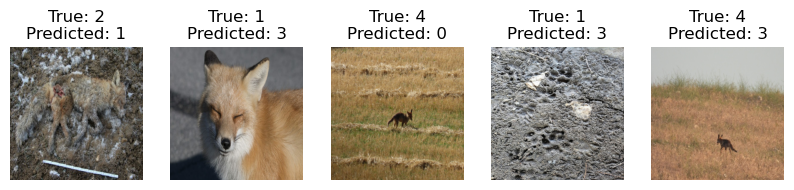

In [94]:
for images, labels in val_ds.take(1):
    labels = labels.numpy()
    predictions = [tf.argmax(i).numpy() for i in model.predict(images)]
    misclassified_indices = [i for i in range(len(predictions)) if predictions[i] != labels[i]]
    misclassified_images = [images[i] for i in misclassified_indices]

    plt.figure(figsize=(10, 10))
    for i in range(len(misclassified_images)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(misclassified_images[i].numpy().astype("uint8"))
        plt.title(f"True: {labels[misclassified_indices[i]]}\nPredicted: {predictions[misclassified_indices[i]]}")
        plt.axis('off')

    plt.show()

In [37]:
model.evaluate(test_ds)

2024-01-04 00:05:53.404915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1135]
	 [[{{node Placeholder/_0}}]]
2024-01-04 00:05:53.406405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1135]
	 [[{{node Placeholder/_4}}]]


94/94 [==============================] - 1s 8ms/step - loss: 1.6366 - accuracy: 0.4003


[1.6366156339645386, 0.40026596188545227]